Get the credentials by going to OOI website

[OOI](https://ooinet.oceanobservatories.org)

__Data request__

In [1]:
import datetime
import yodapy
from yodapy.core import OOIASSET

In [8]:
username = ''
token = ''
yodapy.utils.set_credentials_file(username= username, token= token)
asset = OOIASSET.from_reference_designator('RS01SBPS-SF01A-2A-CTDPFA102')

stdt = datetime.datetime(2018, 1, 1)
enddt = datetime.datetime(2018, 1, 30)

asset.request_data(
    begin_date=stdt,
    end_date=enddt
)

Please wait while data is compiled.


'https://opendap.oceanobservatories.org/thredds/catalog/ooi/pshivraj@uw.edu/20180530T192834-RS01SBPS-SF01A-2A-CTDPFA102-streamed-ctdpf_sbe43_sample/catalog.html'

Check the above url for genrated data, once done hit the next cell. This might take a minute or two

In [9]:
%%capture
ds = asset.to_xarray()

__Data Analysis__

In [10]:
from IPython import display
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import netCDF4 as nc
import pandas as pd
import requests
from scipy import constants

In [11]:
# Extracting desired variables to be analyzed.
ds_time = ds['time'].values
pressure = ds['seawater_pressure'].values
temperature = ds['seawater_temperature'].values

In [12]:
sample_data = pd.DataFrame({'time' : ds_time , 'pressure': pressure, 'temperature' : temperature})
#changinf time zone to Pacific
sample_data['time'] = pd.to_datetime(sample_data['time']).dt.tz_localize('UTC')
sample_data['local_time'] = sample_data['time'].dt.tz_convert('US/Pacific')

# adding offset of -1 for Axial Seamount time zone
sample_data['local_time'] = sample_data['local_time'] +  pd.DateOffset(hours=-1)
sample_data['local_time'] = sample_data['local_time'].dt.floor('s')
sample_data['date'] = sample_data['local_time'].dt.date
sample_data['hour'] = sample_data['local_time'].dt.hour

#removing localization from timestamp.
sample_data['local_time'] = sample_data['local_time'].dt.tz_localize(None)
sample_data.head(5)

,pressure,temperature,time,local_time,date,hour
0,190.106058,7.915867,2018-01-01 00:00:00.415237120+00:00,2017-12-31 15:00:00,2017-12-31,15
1,190.099638,7.915804,2018-01-01 00:00:01.416078336+00:00,2017-12-31 15:00:01,2017-12-31,15
2,190.096456,7.915804,2018-01-01 00:00:02.416397824+00:00,2017-12-31 15:00:02,2017-12-31,15
3,190.094316,7.915741,2018-01-01 00:00:03.416716288+00:00,2017-12-31 15:00:03,2017-12-31,15
4,190.093260,7.915804,2018-01-01 00:00:04.415160320+00:00,2017-12-31 15:00:04,2017-12-31,15


In [13]:
#grouping the data to analyze temperature and pressure(depth)
grouped_data = sample_data[['local_time','temperature','pressure']].groupby('local_time').mean()

In [14]:
#binning of temperature
grouped_data['temp_bin'] = pd.cut(grouped_data.temperature, bins=[6, 8, 9, 13], labels=['cold','mild','warm'])
map_temp = {'cold': 'blue', 'mild': 'orange','warm':'red'}
grouped_data.replace({"temp_bin": map_temp},inplace=True)
grouped_data.head(5)

,temperature,pressure,temp_bin
local_time,,,
2017-12-31 15:00:00,7.915867,190.106058,blue
2017-12-31 15:00:01,7.915804,190.099638,blue
2017-12-31 15:00:02,7.915804,190.096456,blue
2017-12-31 15:00:03,7.915741,190.094316,blue
2017-12-31 15:00:04,7.915804,190.093260,blue


Plotly would require one time credentials to make the plot, once ran it wont require credentials on a particular system.

[Plotly Signup](https://plot.ly/settings/api#/)

In [15]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='',api_key='')

df = grouped_data[(grouped_data.index > '2018-01-01') & (grouped_data.index < '2018-01-07')]
trace = go.Scatter(x=df.index[::200],
                   y=df.pressure[::200],
                   mode='markers+text',
                   marker=dict(color=df.temp_bin.values[::200]))

data = [trace]
layout = dict(
    title='Dept vs Time with Temperature color coded',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict()
    ),
    yaxis = dict(
      title = "Depth",
      autorange ='reversed'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig,filename = 'basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~pshivraj/0 or inside your plot.ly account where it is named 'basic-line'


As we can see Noon time ascend for Nitrate collection looks fine (starts at around '11:45') with timeshift of 1 hour from Pacific Time, 
however Night time ascend for Nitrate starts at around '22:25'

__Winch Stuck__

It looks like winch got stuck twice in the month of Jan 2018. Lets plot and see when it happened.

In [16]:
import plotly
import plotly.plotly as py
import plotly.graph_objs as go
# plotly.tools.set_credentials_file(username='',api_key='')

#skipping 200 consecutive values as the values are quite similar and redundant to analysis.
df = grouped_data[(grouped_data.index > '2018-01-01') & (grouped_data.index < '2018-01-30')]
trace = go.Scatter(x=df.index[::200],
                   y=df.pressure[::200],
                   mode='markers+text',
                   marker=dict(color=df.temp_bin.values[::200]))

data = [trace]
layout = dict(
    title='Dept vs Time with Temperature color coded',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(count=1,
                    label='YTD',
                    step='year',
                    stepmode='todate'),
                dict(count=1,
                    label='1y',
                    step='year',
                    stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict()
    ),
    yaxis = dict(
      title = "Depth",
      autorange ='reversed'
    ),
)

fig = dict(data=data, layout=layout)
py.iplot(fig,filename = 'basic-line')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~pshivraj/0 or inside your plot.ly account where it is named 'basic-line'


So its on Two days 5th of Jan 2018 (from Midnight till morning 9) at depth around 195m
and on 25th of Jan(from midnight till morning 6) around 30m.
Additionally there is no data from '18th Jan 18:00 'till '19th Jan 19:00'.

Let look at if we can detect the pattern when it got stuck.

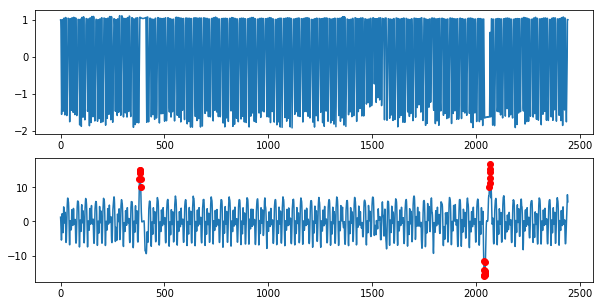

In [17]:
#let decide a step function which has upper and lower bounds similar to our standardize data.
step_function = np.concatenate([[-1]*10,[1]*10])
grouped_data =  grouped_data[::1000]

#standardise the data for correlation calculation 
depth = (grouped_data.pressure - grouped_data.pressure.mean())/grouped_data.pressure.std()

#calculate the correlation of our predefined step function with existing data
corr_val = np.correlate(depth, step_function,mode='same')

# setting a threshold for anomalies
th = 10
plt.figure(figsize=(10,5))
plt.subplot(211)
plt.plot(depth.values)
plt.subplot(212)
plt.plot(corr_val)
plt.plot(np.arange(len(corr_val))[(corr_val > th) + (corr_val < -th)],corr_val[(corr_val > th) + (corr_val < -th)],'ro')
plt.show()

As we can see a basic correlation measure can reveal that we do have some anomalies happening around 5th and 25th.